<a href="https://colab.research.google.com/github/techieAKR/Masters-ParallelComputing/blob/main/sheet-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scalar-products

In [9]:
import numpy as np
import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numexpr as ne


def generate_vectors(size: int = 160):
    """Generate two random vectors of specified size."""
    A = np.random.rand(size)
    B = np.random.rand(size)
    return A, B

def sequential_scalar_product(A, B):
    """Calculate scalar product sequentially."""
    return np.dot(A, B)

def parallel_chunk_multiply(chunk):
    """Helper function for parallel processing - multiplies chunk of vectors."""
    chunk_A, chunk_B = zip(*chunk)  # Unzip the chunk
    return ne.evaluate("sum(a * b)", local_dict={"a": chunk_A, "b": chunk_B})

def parallel_scalar_product(A, B, num_processors):
    """Calculate scalar product in parallel using Joblib."""
    from numpy import array_split

    chunks = array_split(list(zip(A, B)), num_processors)  # Adjust num_processors

    results = Parallel(n_jobs=num_processors)(delayed(parallel_chunk_multiply)(chunk) for chunk in chunks)

    return sum(results)

def measure_performance(vector_size, num_processors, num_trials=1):
    """Measure performance of sequential vs parallel implementation."""
    seq_times = []
    par_times = []

    for _ in range(num_trials):
        A, B = generate_vectors(vector_size)

        # Measure sequential time
        start = time.time()
        sequential_scalar_product(A, B)
        seq_times.append(time.time() - start)

        # Measure parallel time
        start = time.time()
        parallel_scalar_product(A, B, num_processors)
        par_times.append(time.time() - start)

    return np.mean(seq_times), np.mean(par_times)

def calculate_metrics(seq_time, par_time, num_processors):
    """Calculate speedup and efficiency."""
    speedup = seq_time / par_time
    efficiency = speedup / num_processors
    return speedup, efficiency

def plot_speedup(sizes, num_processors=8):
    """Create visualization of speedup for different vector sizes."""
    results = []

    for size in sizes:
        seq_time, par_time = measure_performance(size, num_processors)
        speedup, efficiency = calculate_metrics(seq_time, par_time, num_processors)
        results.append({
            'size': size,
            'sequential_time': seq_time,
            'parallel_time': par_time,
            'speedup': speedup,
            'efficiency': efficiency
        })

    return results

def visualize_performance(results):
    """
    Visualize performance metrics

    Args:
    results (dict): Performance measurement results
    """
    metrics = ['sequential_time', 'parallel_time', 'speedup', 'efficiency']
    values = [results[metric] for metric in metrics]

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, values)
    plt.title('Performance Comparison')
    plt.ylabel('Time / Speedup / Efficiency')
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

def main():
    # Vector configuration
    sizes = [10000, 50000]
    results = plot_speedup(sizes)

    # Accessing the results using the correct keys
    print("\nPerformance Metrics:")
    print(f"Sequential Time: {results[0]['sequential_time']:.6f} seconds") # Accessing sequential_time from the first result
    print(f"Parallel Time:   {results[0]['parallel_time']:.6f} seconds") # Accessing parallel_time from the first result
    print(f"Speedup (S8):    {results[0]['speedup']:.4f}") # Accessing speedup from the first result
    print(f"Efficiency (E8): {results[0]['efficiency']:.4f}") # Accessing efficiency from the first result

    # Visualize results
    visualize_performance(results[0])  # Passing the first result to visualize_performance


# ... (Your existing code) ...

if __name__ == "__main__":
    sizes = [100000, 500000]
    results = plot_speedup(sizes)

    # Print detailed results
    print("\nDetailed Results:")
    print("Size\tSeq Time\tPar Time\tSpeedup\tEfficiency")
    print("-" * 60)
    for r in results:
        print(f"{r['size']}\t{r['sequential_time']:.6f}\t{r['parallel_time']:.6f}\t"
              f"{r['speedup']:.2f}\t{r['efficiency']:.2f}")


Detailed Results:
Size	Seq Time	Par Time	Speedup	Efficiency
------------------------------------------------------------
100000	0.001418	0.203022	0.01	0.00
500000	0.000672	0.904105	0.00	0.00


# matrix-multiplication

Running performance tests using 2 CPU cores

Performance Measurements:
------------------------------------------------------------
Size	Sequential	Parallel	Speedup	Efficiency
------------------------------------------------------------
50	0.0462s	2.5970s	0.02x	0.0089
100	0.1852s	20.5634s	0.01x	0.0045
150	0.6538s	93.6921s	0.01x	0.0035


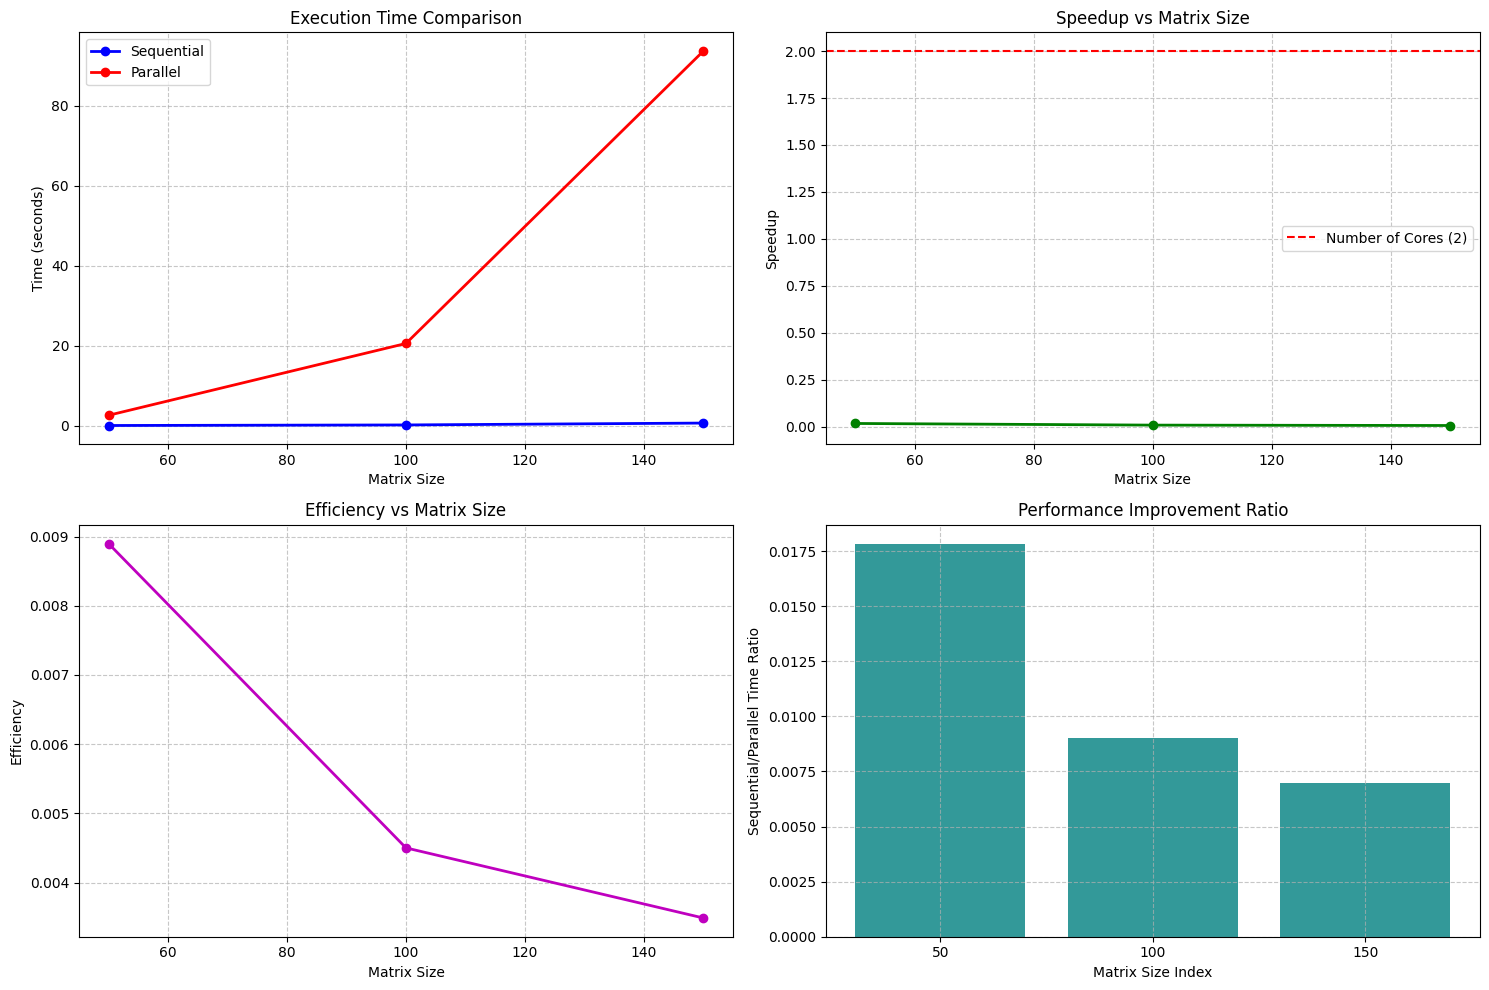

In [10]:

"""
Install the matplotlib, you must have venv also.

"""

import multiprocessing as mp
from time import time
import random
from concurrent.futures import ProcessPoolExecutor
import itertools
import matplotlib.pyplot as plt

def generate_random_matrix(n):
    """Generate random n x n matrix"""
    return [[random.random() for _ in range(n)] for _ in range(n)]

def matrix_multiply_element(params):
    """Compute single element of resulting matrix"""
    i, j, A, B = params
    n = len(A)
    return i, j, sum(A[i][k] * B[k][j] for k in range(n))

def sequential_matrix_mult(A, B):
    """Sequential matrix multiplication"""
    n = len(A)
    C = [[0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i][j] += A[i][k] * B[k][j]
    return C

def parallel_matrix_mult(A, B):
    """Parallel matrix multiplication"""
    n = len(A)
    C = [[0 for _ in range(n)] for _ in range(n)]

    params = [(i, j, A, B) for i, j in itertools.product(range(n), range(n))]

    with ProcessPoolExecutor(max_workers=mp.cpu_count()) as executor:
        results = executor.map(matrix_multiply_element, params)

    for i, j, value in results:
        C[i][j] = value

    return C

def measure_performance(sizes):
    """Measure and compare performance"""
    sequential_times = []
    parallel_times = []
    speedups = []
    efficiencies = []
    num_processors = mp.cpu_count()

    print("\nPerformance Measurements:")
    print("-" * 60)
    print("Size\tSequential\tParallel\tSpeedup\tEfficiency")
    print("-" * 60)

    for n in sizes:
        # Generate random matrices
        A = generate_random_matrix(n)
        B = generate_random_matrix(n)

        # Measure sequential time
        start = time()
        C_seq = sequential_matrix_mult(A, B)
        seq_time = time() - start
        sequential_times.append(seq_time)

        # Measure parallel time
        start = time()
        C_par = parallel_matrix_mult(A, B)
        par_time = time() - start
        parallel_times.append(par_time)

        # Calculate metrics
        speedup = seq_time / par_time if par_time > 0 else 0
        speedups.append(speedup)

        efficiency = speedup / num_processors
        efficiencies.append(efficiency)

        # Print results
        print(f"{n}\t{seq_time:.4f}s\t{par_time:.4f}s\t{speedup:.2f}x\t{efficiency:.4f}")

    return sequential_times, parallel_times, speedups, efficiencies

def plot_results(sizes, sequential_times, parallel_times, speedups, efficiencies):
    """Create visualization of performance metrics"""
    # Set up the figure and axes with a clean style
    plt.style.use('default')
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Execution Times
    plt.subplot(221)
    plt.plot(sizes, sequential_times, 'b-o', label='Sequential', linewidth=2)
    plt.plot(sizes, parallel_times, 'r-o', label='Parallel', linewidth=2)
    plt.xlabel('Matrix Size')
    plt.ylabel('Time (seconds)')
    plt.title('Execution Time Comparison')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Speedup
    plt.subplot(222)
    plt.plot(sizes, speedups, 'g-o', linewidth=2)
    plt.axhline(y=mp.cpu_count(), color='r', linestyle='--',
                label=f'Number of Cores ({mp.cpu_count()})')
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup')
    plt.title('Speedup vs Matrix Size')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Efficiency
    plt.subplot(223)
    plt.plot(sizes, efficiencies, 'm-o', linewidth=2)
    plt.xlabel('Matrix Size')
    plt.ylabel('Efficiency')
    plt.title('Efficiency vs Matrix Size')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Performance Improvement Ratio
    plt.subplot(224)
    time_ratios = [s/p if p > 0 else 0 for s, p in zip(sequential_times, parallel_times)]
    plt.bar(range(len(sizes)), time_ratios, alpha=0.8, color='teal')
    plt.xlabel('Matrix Size Index')
    plt.ylabel('Sequential/Parallel Time Ratio')
    plt.title('Performance Improvement Ratio')
    plt.xticks(range(len(sizes)), sizes)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('matrix_multiplication_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Set random seed for reproducibility
    random.seed(42)

    # Different matrix sizes
    sizes = [50, 100, 150]
    # sizes = [5]

    print(f"Running performance tests using {mp.cpu_count()} CPU cores")

    # Measure performance
    sequential_times, parallel_times, speedups, efficiencies = measure_performance(sizes)

    # Plot results
    plot_results(sizes, sequential_times, parallel_times, speedups, efficiencies)

if __name__ == '__main__':
    main()